## Study of type event recognition for the PETALO experiment using ML

### Imports

In [1]:
import numpy  as np
import pandas as pd
import random

from random import randrange, uniform

import matplotlib.pyplot as plt

In [2]:
#in terminal set the course conda env: conda activate machine-learning-course
from tensorflow.keras               import layers
from tensorflow.keras               import regularizers
from tensorflow.keras.utils         import to_categorical
from tensorflow.keras.models        import Sequential
from tensorflow.keras.layers        import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image

### Loading data:

Code to select events and plotting utils in https://github.com/carmenromo/Analysis/tree/master/machine_learning_course

In [3]:
phot_list, compt_list = [], []
data_file  = '/Users/carmenromoluque/machine-learning-course/full_body_4cmdepth_all_images.npz'
data       = np.load(data_file, allow_pickle=True)
for im in data['phot_images']:
    if len(im)==0:
        continue
    phot_list .append(im.reshape(400))
for im in data['compt_images']:
    if len(im)==0:
        continue
    compt_list.append(im.reshape(400))
compt_images = np.array(compt_list)
phot_images  = np.array(phot_list)

#### Create the noisy events

In [4]:
noise_images = 20 *np.random.rand(5000, 400) #20 has been chosen randomly

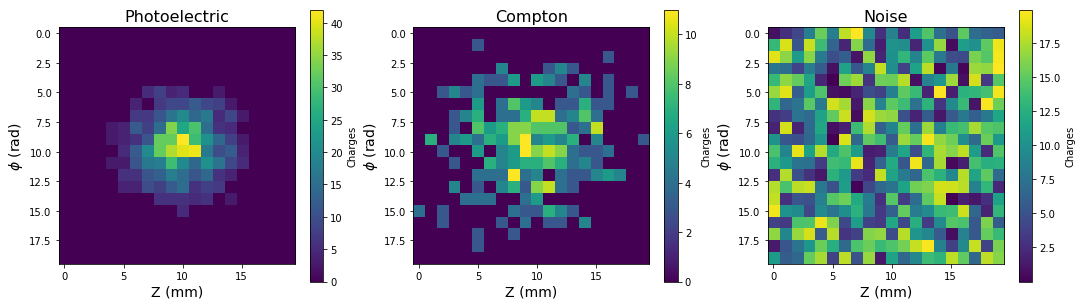

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,5))
fig1 = ax1.imshow( phot_images[4].reshape(20,20))
fig2 = ax2.imshow(compt_images[9].reshape(20,20))
fig3 = ax3.imshow(noise_images[0].reshape(20,20))
ax1.set_xlabel('Z (mm)',       size=14)
ax1.set_ylabel('$\phi$ (rad)', size=14)
ax1.set_title('Photoelectric', size=16)
ax2.set_xlabel('Z (mm)',       size=14)
ax2.set_ylabel('$\phi$ (rad)', size=14)
ax2.set_title('Compton',       size=16)
ax3.set_xlabel('Z (mm)',       size=14)
ax3.set_ylabel('$\phi$ (rad)', size=14)
ax3.set_title('Noise',         size=16)
fig.colorbar(fig1, ax=ax1, label='Charges')
fig.colorbar(fig2, ax=ax2, label='Charges')
fig.colorbar(fig3, ax=ax3, label='Charges')
plt.show()

In the previous plot I have chosen ideal images of photoelectric and compton (phot more compact and compton more sparse), because I found that the pattern in the sipms is pretty similar between these two kinds of events, that's why I would be so happy if the CNN manages to distinguish them successfully.

#### Create the labels:
- compton:       0
- photoelectric: 1
- noise:         2

In [6]:
compt_labels =   np.zeros(len(compt_images))
phot_labels  =   np.ones (len( phot_images))
noise_labels = 2*np.ones (len(noise_images))

### Normalization:

Data can be normalized either using the maximum charge corresponding to every event type or either using the maximum absolute charge value. I think the most correct is the second option because maybe we are missing some information in the number of charges between photoelectric and compton events.

However I find better results in the previous one...

In [7]:
max_charges = [np.max( phot_images), np.max(compt_images), np.max(noise_images)]
abs_max = max(max_charges)
abs_max

1168.0

In [8]:
#norm_phot_images  =  phot_images/abs_max
#norm_compt_images = compt_images/abs_max
#norm_noise_images = noise_images/abs_max

norm_phot_images  =  phot_images/np.max( phot_images)
norm_compt_images = compt_images/np.max(compt_images)
norm_noise_images = noise_images/np.max(noise_images)

## Inputs for the CNN:

In [9]:
y = np.concatenate((compt_labels,     phot_labels,       noise_labels))
x = np.concatenate((norm_phot_images, norm_compt_images, norm_noise_images))
#x = np.concatenate((phot_images, compt_images, noise_images))
print(y.shape)
print(x.shape)
print(y)

(47176,)
(47176, 400)
[0. 0. 0. ... 2. 2. 2.]


We want to mix the images so that they are not in order (but labels in the same way too):

In [10]:
c = list(zip(x, y))
np.random.shuffle(c)
x, y = zip(*c)
y = np.array(y)
x = np.array(x).astype('float32')

Split data in training, validation and testing:

In [11]:
#######
train_split = 40000
#######
test_split  = 2000
#######

y_train = y[                 :train_split]
x_train = x[                 :train_split]
y_val   = y[train_split      :len(y)-test_split]
x_val   = x[train_split      :len(x)-test_split]
y_test  = y[len(y)-test_split:                 ]
x_test  = x[len(x)-test_split:                 ]


#x_rgb_train_cnn, x_rgb_val_cnn, y_rgb_train_hot, y_rgb_val_hot = train_test_split(x_rgb_cnn,
#                                                                                   y_rgb_hot,
#                                                                                   test_size = 0.1,
#                                                                                   stratify = y_rgb_hot,
#                                                                                   shuffle = True,
#                                                                                   random_state = 42)

In [12]:
print(x_test .shape, y_test .shape)
print(x_train.shape, y_train.shape)
print(x_val  .shape, y_val  .shape)

(2000, 400) (2000,)
(40000, 400) (40000,)
(5176, 400) (5176,)


In [13]:
myset     = set(y_train)
mysettest = set(y_test)
print(myset)
print(mysettest)
print(y)

{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}
[1. 0. 1. ... 2. 1. 0.]


In [14]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(y_train_hot.shape)
print(y_val_hot  .shape)
print(y_test_hot .shape)

(40000, 3)
(5176, 3)
(2000, 3)


40000 train samples
5176 validation samples


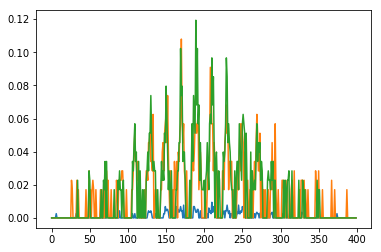

In [15]:
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
plt.plot(x_train[0])
plt.plot(x_train[1])
plt.plot(x_test[2])
plt.show()

Reshape data for CNN:

In [16]:
x_train_cnn = x_train.reshape(-1, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 20, 20, 1)
x_train_cnn.shape

(40000, 20, 20, 1)

In [39]:
layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

# a fairly small network for speed
cnnmodel = Sequential()
#cnnmodel.add(Conv2D(128, (4, 4), activation='relu', input_shape=(20, 20, 1)))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(MaxPooling2D((3, 3))) #Max pooling operation for 2D spatial data.
#cnnmodel.add(layer)
#cnnmodel.add(Dropout(0.4, input_shape=(20,20,1)))
#cnnmodel.add(Conv2D(256, (4, 4), activation='relu'))
##cnnmodel.add(Conv2D(128, (3, 3), activation='relu'))
#cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1, input_shape=(20,20,1)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(3, activation='softmax'))
#
cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='adam', #RMSprop(),
                metrics=['accuracy'])

cnnmodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 18, 18, 64)        640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 6915      
Total params: 7,555
Trainable params: 7,555
Non-trainable params: 0
_________________________________________________________________


In [40]:
batch_size = 20
epochs     = 10

Train the CNN:

In [41]:
# Training our CNN
history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot))

Train on 40000 samples, validate on 5176 samples
Epoch 1/10
40000/40000 [==============================] - 16s 396us/sample - loss: 0.1837 - accuracy: 0.9414 - val_loss: 0.1671 - val_accuracy: 0.9505
Epoch 2/10
40000/40000 [==============================] - 14s 357us/sample - loss: 0.1598 - accuracy: 0.9507 - val_loss: 0.1605 - val_accuracy: 0.9496
Epoch 3/10
40000/40000 [==============================] - 14s 357us/sample - loss: 0.1594 - accuracy: 0.9507 - val_loss: 0.1605 - val_accuracy: 0.9505
Epoch 4/10
40000/40000 [==============================] - 14s 349us/sample - loss: 0.1591 - accuracy: 0.9507 - val_loss: 0.1652 - val_accuracy: 0.9498
Epoch 5/10
40000/40000 [==============================] - 16s 390us/sample - loss: 0.1591 - accuracy: 0.9509 - val_loss: 0.1670 - val_accuracy: 0.9505
Epoch 6/10
40000/40000 [==============================] - 14s 338us/sample - loss: 0.1585 - accuracy: 0.9509 - val_loss: 0.1598 - val_accuracy: 0.9505
Epoch 7/10
40000/40000 [=====================

In [27]:
def histplot(history):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss','val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy','val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')

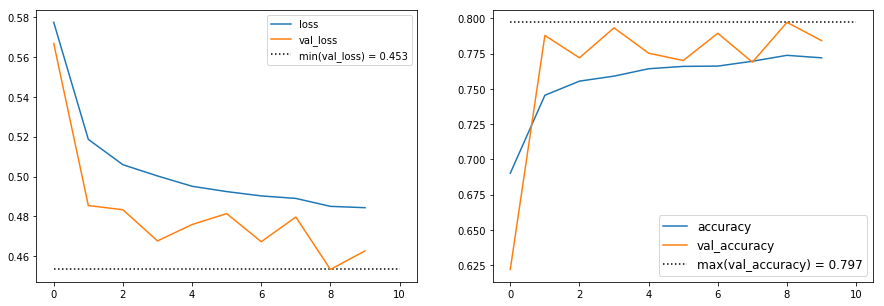

In [53]:
histplot(history)

In [54]:
prediction = []
for i in range(len(x_test_cnn)):
    img = x_test_cnn[i]
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    pred = cnnmodel.predict(test_image)
    prediction.append(pred)

In [55]:
print(len(prediction))
print(prediction[15])
print(np.round(prediction[15]))
print(y_test[15])

2000
[[1.05607726e-01 8.94392252e-01 1.03755539e-10]]
[[0. 1. 0.]]
1.0


In [69]:
print(len(y_test[y_test==2]))
len(np.array(prediction)[y_test==2][np.round(prediction).item(2)==1])

190


0

In [65]:
#true_results = np.equal(y_test, result)
y_test[0]
#np.array(prediction)[0]

1.0

In [57]:
result=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result.append(0)
    elif np.round(prediction[i]).item(1)==1:
        result.append(1)
    else:
        result.append(2)
result = np.array(result)

result_translate = ['Compt', 'Phot', 'Noise']
result_names = []
for i in range(len(result)):
    result_names.append(result_translate[result[i]])
result_names = np.array(result_names)

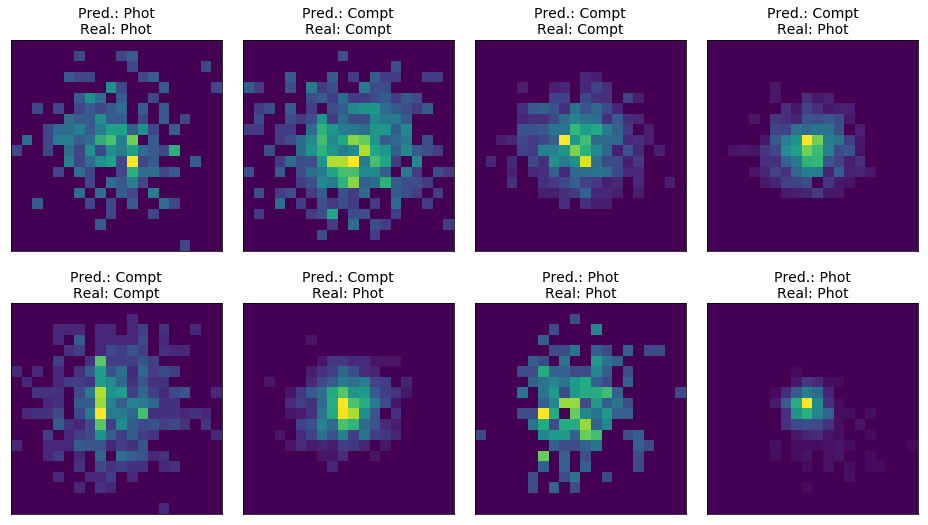

In [58]:
x_test_image = x_test.reshape(len(x_test),20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i+30], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i+30]}'+ '\n' F'Real: {result_translate[int(y_test[i+30])]}', fontsize=14)
plt.tick_params()

In [59]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('------------------------------')

------------------------------
# CORRECT PREDICTIONS:
1581 of total 2000 ---> 79.05 %
------------------------------


## Noise accuracy

Instead of generating random noise, I am going to use gaussian distributions

In [36]:
def multivariate_gaussian(pos, mu, sigma):
    n         = mu.shape[0]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    N         = np.sqrt((2*np.pi)**n * sigma_det)
    fac       = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
    return np.exp(-fac/2)/N

In [37]:
n_bins  = 20
n_dist  = 10000
gauss2d = []
for i in range(n_dist):
    x_rand = np.linspace(-randrange(1, 10), randrange(1, 10), n_bins)
    y_rand = np.linspace(-randrange(1, 10), randrange(1, 10), n_bins)
    x_rand, y_rand = np.meshgrid(x_rand, y_rand)
    # Mean vector and covariance matrix
    mu = np.array([0., randrange(1, 3)])
    sigma = np.array([[uniform(0.5, 2), -0.5], [-0.5, uniform(0.5, 2)]])
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x_rand.shape + (2,))
    pos[:, :, 0] = x_rand
    pos[:, :, 1] = y_rand
    # The distribution on the variables X, Y packed into pos.
    gauss2d = np.append(gauss2d, multivariate_gaussian(pos, mu, sigma))

gauss2d = gauss2d.reshape(n_dist, 400)

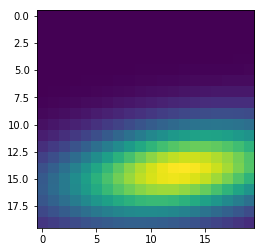

In [38]:
plt.imshow(gauss2d[0].reshape(20, 20));

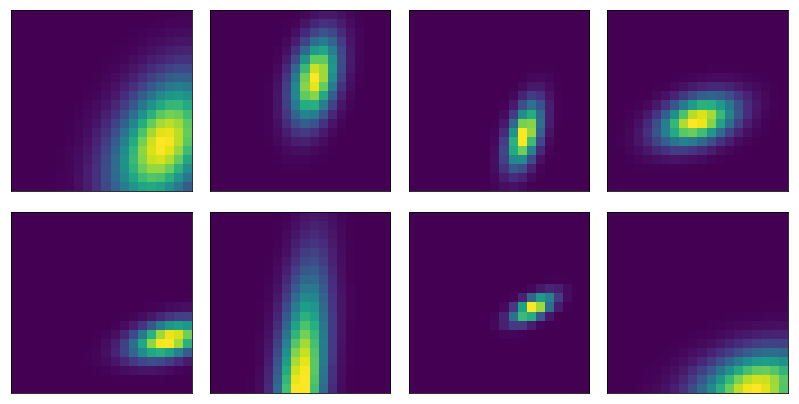

In [39]:
gauss2d_image = gauss2d.reshape(len(gauss2d),20,20)
fig = plt.figure(figsize=(12, 10))  # figure size in inches
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(gauss2d_image[randrange(1, len(gauss2d))], interpolation='nearest')

In [40]:
gauss2d.shape

(10000, 400)

In [41]:
norm_gauss2d = gauss2d/np.max(gauss2d)

In [42]:
noise_images      = gauss2d
norm_noise_images = norm_gauss2d

### Train the net again:

In [43]:
y = np.concatenate((compt_labels,     phot_labels,       noise_labels))
x = np.concatenate((norm_phot_images, norm_compt_images, norm_noise_images))

c = list(zip(x, y))
np.random.shuffle(c)
x, y = zip(*c)
y = np.array(y)
x = np.array(x).astype('float32') 
#######
train_split = 40000
#######
test_split  = 2000
#######

y_train = y[:train_split]
x_train = x[:train_split]
y_val   = y[train_split:len(y) - test_split]
x_val   = x[train_split:len(x) - test_split]
y_test  = y[len(y)-test_split :]
x_test  = x[len(x)-test_split :]

40000 train samples
5176 validation samples


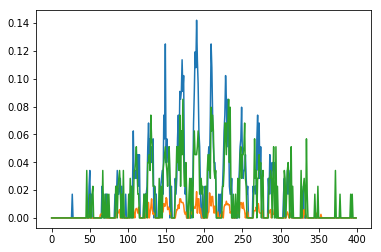

In [44]:
y_train_hot = to_categorical(y_train)
y_val_hot   = to_categorical(y_val)
y_test_hot  = to_categorical(y_test)

print(x_train.shape[0], 'train samples')
print(x_val  .shape[0], 'validation samples')
plt.plot(x_train[0])
plt.plot(x_train[1])
plt.plot(x_test [2])
plt.show()

In [45]:
x_train_cnn = x_train.reshape(-1, 20, 20, 1)
x_test_cnn  = x_test .reshape(-1, 20, 20, 1)
x_val_cnn   = x_val  .reshape(-1, 20, 20, 1)

layer = layers.Dense(
    units=64,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5))

cnnmodel = Sequential()
cnnmodel.add(Conv2D(64, (3, 3), activation='relu', input_shape=(20, 20, 1))) #2D convolution layer
cnnmodel.add(MaxPooling2D((3, 3))) #Max pooling operation for 2D spatial data.
cnnmodel.add(layer)
cnnmodel.add(Dropout(0.4, input_shape=(20,20,1)))
cnnmodel.add(Conv2D(256, (4, 4), activation='relu'))
cnnmodel.add(MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1, input_shape=(20,20,1)))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(3, activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
                optimizer='adam', #RMSprop(),
                metrics=['accuracy'])

cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 18, 18, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 6, 6, 64)          4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 256)         262400    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 1, 256)        

In [46]:
batch_size = 32
epochs     = 10

history = cnnmodel.fit(x_train_cnn, y_train_hot,
                       batch_size=batch_size, 
                       epochs=epochs,
                       verbose=1,
                       validation_data=(x_val_cnn, y_val_hot))

Train on 40000 samples, validate on 5176 samples
Epoch 1/10
40000/40000 [==============================] - 41s 1ms/sample - loss: 0.2446 - accuracy: 0.9273 - val_loss: 0.2091 - val_accuracy: 0.9411
Epoch 2/10
40000/40000 [==============================] - 39s 965us/sample - loss: 0.1936 - accuracy: 0.9428 - val_loss: 0.1912 - val_accuracy: 0.9405
Epoch 3/10
40000/40000 [==============================] - 39s 969us/sample - loss: 0.1867 - accuracy: 0.9447 - val_loss: 0.1776 - val_accuracy: 0.9447
Epoch 4/10
40000/40000 [==============================] - 39s 970us/sample - loss: 0.1832 - accuracy: 0.9452 - val_loss: 0.2128 - val_accuracy: 0.9343
Epoch 5/10
40000/40000 [==============================] - 39s 977us/sample - loss: 0.1772 - accuracy: 0.9467 - val_loss: 0.1786 - val_accuracy: 0.9451
Epoch 6/10
40000/40000 [==============================] - 43s 1ms/sample - loss: 0.1771 - accuracy: 0.9470 - val_loss: 0.1741 - val_accuracy: 0.9461
Epoch 7/10
40000/40000 [=========================

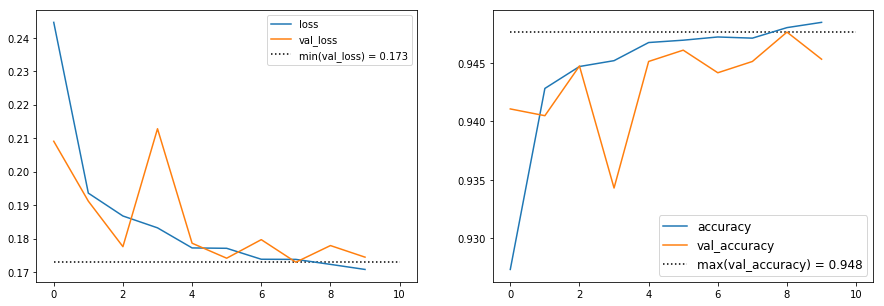

In [47]:
histplot(history)

In [48]:
prediction = []
for i in range(len(x_test_cnn)):
    img = x_test_cnn[i]
    test_image = image.img_to_array(img)
    test_image = np.expand_dims(test_image, axis=0)
    pred = cnnmodel.predict(test_image)
    prediction.append(pred)

In [49]:
result=[]
for i in range(len(prediction)):
    if np.round(prediction[i]).item(0)==1:
        result.append(0)
    elif np.round(prediction[i]).item(1)==1:
        result.append(1)
    else:
        result.append(2)
result = np.array(result)

result_translate = ['Compt', 'Phot', 'Noise']
result_names = []
for i in range(len(result)):
    result_names.append(result_translate[result[i]])
result_names = np.array(result_names)

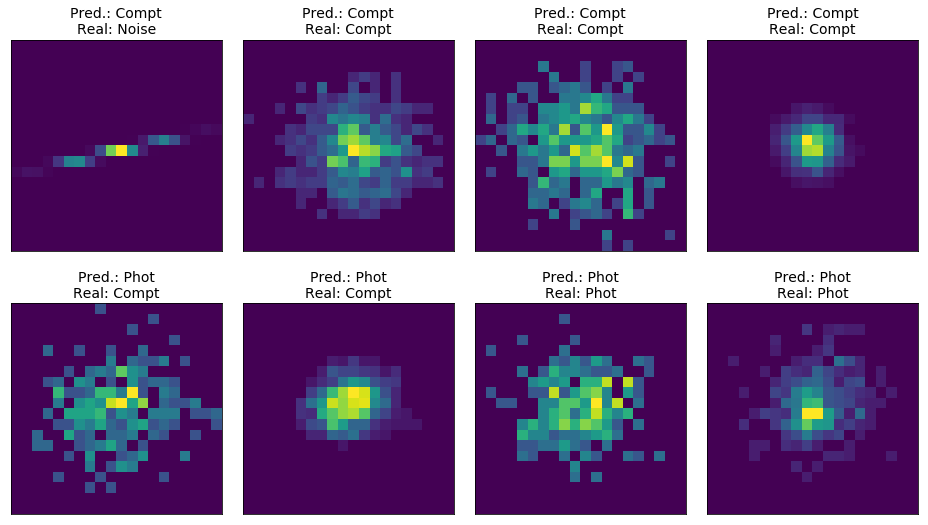

In [50]:
x_test_image = x_test.reshape(len(x_test),20,20)
fig = plt.figure(figsize=(14, 13))
fig.subplots_adjust(left=0, right=0.9, bottom=0, top=1.1, hspace=0.1, wspace=0.1)
for i in range(8):
    ax = fig.add_subplot(4, 4, i+1 , xticks=[], yticks=[])
    ax.imshow(x_test_image[i], interpolation='nearest')
    
    # label the image with the target value
    ax.set_title(F'Pred.: {result_names[i]}'+ '\n' F'Real: {result_translate[int(y_test[i])]}', fontsize=14)
plt.tick_params()

In [51]:
true_results = np.equal(y_test, result)
percentage   = np.round(sum(true_results)/len(y_test)*100, decimals=2)
print('------------------------------')
print('# CORRECT PREDICTIONS:')
print(f'{sum(true_results)} of total {len(y_test)} ---> {percentage} %')
print('------------------------------')

------------------------------
# CORRECT PREDICTIONS:
1892 of total 2000 ---> 94.6 %
------------------------------
